In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cmocean 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from scipy import stats
from matplotlib.colors import TwoSlopeNorm
import regionmask
import pandas as pd
from matplotlib import colors
from pathlib import Path
import string
import matplotlib.ticker as mticker


In [63]:
def open_ds(filename: str) -> xr.Dataset:
    """Open an xarray Dataset."""
    return xr.open_dataset(BASE / filename)

def mean_over_time(ds: xr.Dataset, mean_var: str, std_var: str, time_dim: str = "time"):
    """Return time-mean of the mean and std variables."""
    return ds[mean_var].mean(time_dim), ds[std_var].mean(time_dim)

import numpy as np
import xarray as xr
from scipy.stats import t

def check_same_shape(name, m1, s1, m2, s2):
    shapes = [m1.shape, s1.shape, m2.shape, s2.shape]
    dims   = [m1.dims,  s1.dims,  m2.dims,  s2.dims]
    ok = (shapes[0]==shapes[1]==shapes[2]==shapes[3]) and (dims[0]==dims[1]==dims[2]==dims[3])
    if not ok:
        print(f"[SHAPE MISMATCH] {name}:")
        print(f"  mean_ctrl: {m1.shape} {m1.dims}")
        print(f"  std_ctrl : {s1.shape} {s1.dims}")
        print(f"  mean_sens: {m2.shape} {m2.dims}")
        print(f"  std_sens : {s2.shape} {s2.dims}")
    return ok

def welch_ttest_numpy_wrap(name, mean_ctrl, std_ctrl, mean_sens, std_sens, n_ctrl, n_sens):
    """
    Strict: no coord renaming/aligning. Requires identical dims/shape across inputs.
    Uses NumPy on .values to avoid xarray auto-alignment; wraps result on mean_ctrl coords.
    """
    if not check_same_shape(name, mean_ctrl, std_ctrl, mean_sens, std_sens):
        raise ValueError(f"{name}: inputs are not on the exact same grid/dims.")
    # compute with numpy
    mc = mean_ctrl.values
    sc = std_ctrl.values
    ms = mean_sens.values
    ss = std_sens.values

    se = np.sqrt((sc**2)/n_ctrl + (ss**2)/n_sens)
    # avoid divide-by-zero warnings
    with np.errstate(divide='ignore', invalid='ignore'):
        t_stat = (mc - ms) / se
        df_num = (sc**2/n_ctrl + ss**2/n_sens)**2
        df_den = ((sc**2/n_ctrl)**2)/(n_ctrl - 1) + ((ss**2/n_sens)**2)/(n_sens - 1)
        df = df_num / df_den
        p_val = 2 * (1 - t.cdf(np.abs(t_stat), df))

    t_da = xr.DataArray(t_stat, coords=mean_ctrl.coords, dims=mean_ctrl.dims, name=f"t_{name}")
    p_da = xr.DataArray(p_val, coords=mean_ctrl.coords, dims=mean_ctrl.dims, name=f"p_{name}")
    return t_da, p_da

def run_all_tests_strict(var_dict, n_ctrl, n_sens, alpha=0.05):
    tstats, pvals, sig = {}, {}, {}
    for name, (m1,s1,m2,s2) in var_dict.items():
        t_da, p_da = welch_ttest_numpy_wrap(name, m1, s1, m2, s2, n_ctrl, n_sens)
        tstats[name] = t_da
        pvals[name]  = p_da
        sig[name]    = (p_da < alpha).rename(f"sig_{name}")
    return tstats, pvals, sig

proj = ccrs.Robinson(central_longitude=210)
pc = ccrs.PlateCarree()

def latlon_names(da):
    if 'lat' in da.coords and 'lon' in da.coords:
        return 'lat', 'lon'
    if 'latitude' in da.coords and 'longitude' in da.coords:
        return 'latitude', 'longitude'
    raise ValueError("Couldn't find lat/lon coordinate names in DataArray.")

def nonsig_mask_for(da, sig_mask):
    """Return an int mask (0/1) with dims (lat, lon) matching da for contourf."""
    lat_name, lon_name = latlon_names(da)
    if isinstance(sig_mask, xr.DataArray):
        sig_mask = sig_mask.reindex_like(da, method=None)
    if sig_mask.dims != (lat_name, lon_name):
        sig_mask = sig_mask.transpose(lat_name, lon_name)
    return (~sig_mask).astype(int)

def _style_map_axis(ax, row, nrows=4):
    # Coastlines & land
    ax.coastlines(linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.2)

    # Gridlines (no labels)
    gl = ax.gridlines(crs=pc, draw_labels=False, linewidth=0.3,
                      color="gray", alpha=0.5, linestyle="--")
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
    gl.ylocator = mticker.FixedLocator(np.arange(-60,  61, 30))

    # Add y labels on all panels (optional; comment out if you prefer only left)
    gll = ax.gridlines(crs=pc, draw_labels=True, linewidth=0)
    gll.ylocator = mticker.FixedLocator(np.arange(-60,  61, 30))
    gll.top_labels = False
    gll.bottom_labels = False
    gll.right_labels = False
    gll.ylabel_style = {"size": 8}

    # Bottom panel: x labels
    if row == nrows - 1:
        glb = ax.gridlines(crs=pc, draw_labels=True, linewidth=0)
        glb.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
        glb.top_labels = False
        glb.left_labels = False
        glb.right_labels = False
        glb.xlabel_style = {"size": 8}

import matplotlib as mpl
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Optional but recommended once per notebook/script (publication defaults)
mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "hatch.linewidth": 0.35,
})

def plot_single_model_2x2(
    data_dict,
    sig_masks_dict,
    model_name="SINTEX",
    savepath=None,
):
    """
    Plot 4 panels (2×2) for a single model (publication-ready).

    data_dict format (4 items in desired order):
      - Scalar panels: (da, cmap, levels, cbar_label)
      - Wind panel key MUST match: "850 hPa Wind: Speed & Vectors"
            (ws, cmap, levels, cbar_label, u, v, quiv_scale)
    sig_masks_dict:
      - For scalar panels: boolean DataArray (True = significant)
      - For wind panel: boolean mask for where to plot vectors (True = significant)
    """
    if len(data_dict) != 4:
        raise ValueError("Exactly 4 panels are required for a 2×2 layout.")

    fig, axes = plt.subplots(
        nrows=2, ncols=2,
        figsize=(14, 10),  # ~Nature Comms double-column look (tweak if needed)
        subplot_kw={"projection": proj},
        constrained_layout=True,
    )

    axes = axes.flatten()
    labels = list(string.ascii_lowercase)

    for i, (var_name, data) in enumerate(data_dict.items()):
        ax = axes[i]

        # =========================
        # Panel content
        # =========================
        if var_name == "850 hPa Wind: Speed & Vectors":
            ws, cmap, levels, cbar_label, u_data, v_data, quiv_scale = data

            m = ws.plot(
                ax=ax, transform=pc, cmap=cmap, levels=levels,
                cbar_kwargs={
                    "orientation": "horizontal",
                    "label": cbar_label,
                    "shrink": 0.9,
                    "pad": 0.06,
                    "aspect": 30,
                },
                extend="both",
            )

            # Improve colorbar tick readability
            if hasattr(m, "colorbar") and m.colorbar is not None:
                m.colorbar.ax.tick_params(labelsize=10, length=3, width=0.8)
                m.colorbar.set_label(cbar_label, fontsize=12)

            sig_any = sig_masks_dict[var_name]

            # 1) force mask onto EXACT u grid (coords + dims)
            sig_any = sig_any.reindex_like(u_data, method=None)
            
            lat_name, lon_name = latlon_names(u_data)
            
            # 2) make sure dim order matches
            u2 = u_data.transpose(lat_name, lon_name)
            v2 = v_data.transpose(lat_name, lon_name)
            sig2 = sig_any.transpose(lat_name, lon_name)
            
            # 3) subsample ALL THREE with the same slices
            step = 8
            u_sub = u2.isel({lat_name: slice(0, None, step),
                             lon_name: slice(0, None, step)})
            v_sub = v2.isel({lat_name: slice(0, None, step),
                             lon_name: slice(0, None, step)})
            sig_sub = sig2.isel({lat_name: slice(0, None, step),
                                 lon_name: slice(0, None, step)})
            
            # 4) numpy masking (no alignment surprises)
            mask = sig_sub.values.astype(bool)
            
            u_vals = u_sub.values.copy()
            v_vals = v_sub.values.copy()
            u_vals[~mask] = np.nan
            v_vals[~mask] = np.nan
            
            Q = ax.quiver(
                u_sub[lon_name], u_sub[lat_name],
                u_vals, v_vals,
                transform=pc, scale=quiv_scale,
                width=0.0025, headwidth=5, headlength=6
            )

            ax.quiverkey(
                Q, X=0.88, Y=-0.10, U=2,
                label="2 m s$^{-1}$",
                labelpos="E", coordinates="axes",
                fontproperties={"size": 10},
            )

        else:
            da, cmap, levels, cbar_label = data
            lat_name, lon_name = latlon_names(da)

            plot_kwargs = dict(
                ax=ax, transform=pc, cmap=cmap,
                cbar_kwargs={
                    "orientation": "horizontal",
                    "label": cbar_label,
                    "shrink": 0.9,
                    "pad": 0.06,
                    "aspect": 30,
                },
                extend="both",
            )
            if levels is not None:
                plot_kwargs["levels"] = levels

            m = da.plot(**plot_kwargs)

            # Improve colorbar tick readability
            if hasattr(m, "colorbar") and m.colorbar is not None:
                m.colorbar.ax.tick_params(labelsize=10, length=3, width=0.8)
                m.colorbar.set_label(cbar_label, fontsize=12)

            # Lighter stippling for non-significance (Nature-style)
            sig_mask = sig_masks_dict[var_name]
            nonsig = nonsig_mask_for(da, sig_mask)
            Z = nonsig.transpose(lat_name, lon_name).values
            ax.contourf(
                da[lon_name], da[lat_name], Z,
                levels=[0.5, 1.5],
                colors="none",
                hatches=[".."],   # lighter than "..."
                transform=pc,
                zorder=10,
            )

        # =========================
        # Common styling
        # =========================
        ax.coastlines(linewidth=0.7)
        ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="none", alpha=0.25)

        # IMPORTANT: only ONE gridliner per axis (with labels)
        gl = ax.gridlines(
            crs=pc, draw_labels=True,
            linewidth=0.35, color="gray", alpha=0.5, linestyle="--"
        )
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
        gl.ylocator = mticker.FixedLocator(np.arange(-60, 61, 30))
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()

        # Robinson-friendly label behaviour
        gl.x_inline = False
        gl.y_inline = False
        gl.rotate_labels = False

        # show labels only on outer edges (clean)
        row = i // 2
        col = i % 2
        
        # Latitude labels on BOTH left and right panels
        gl.left_labels  = (col == 0)
        gl.right_labels = (col == 1)
        
        # Longitude labels only on bottom row
        gl.bottom_labels = (row == 1)
        gl.top_labels    = False


        # Panel title (NO exp label, NO suptitle)
        ax.set_title(
            f"({labels[i]}) {var_name}",
            fontsize=14,
            pad=6,
        )


    if savepath is None:
        savepath = f"Figure_{model_name}_2x2.pdf"

    plt.savefig(savepath, dpi=600, bbox_inches="tight")
    plt.show()



In [64]:
BASE = Path("../../../New_Analysis/updated_files/yearly/SINTEX/")

FILES = {
    "temp":  ("clim_ALB_1y_000101_011012_tsurf.nc",
              "clim_zero_1y_190001_195912_tsurf.nc"),
    "pr":    ("clim_ALB_1y_000101_011012_precip.nc",
              "clim_zero_1y_190001_195912_precip.nc"),
    "vp":    ("clim_ALB_1y_000101_011012_velopot200.nc",
              "clim_zero_1y_190001_195912_velopot200.nc"),
    "u850":  ("clim_ALB_1y_000101_011012_u850.nc",
              "clim_zero_1y_190001_195912_u850.nc"),
    "v850":  ("clim_ALB_1y_000101_011012_v850.nc",
              "clim_zero_1y_190001_195912_v850.nc"),
}

In [65]:
ds_sin = {
    "mod":  {k: open_ds(v[0]) for k, v in FILES.items()},
    "zero": {k: open_ds(v[1]) for k, v in FILES.items()},
}

C:\Users\li3n23\miniforge3\envs\work_CMIP\Lib\site-packages\xarray\coding\times.py:170: SerializationWarning: Ambiguous reference date string: 1-01-31 23:54:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-31 23:54:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
C:\Users\li3n23\miniforge3\envs\work_CMIP\Lib\site-packages\xarray\coding\times.py:995: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\li3n23\miniforge3\envs\work_CMIP\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime o

In [66]:
# Map from your ds_sin variable keys -> (mean_var_name, std_var_name)
VARMAP = {
    "temp":  ("tsurf_mean",     "tsurf_std"),
    "pr":    ("precip_mean",    "precip_std"),
    "vp":    ("velopot200_mean","velopot200_std"),
    "u850":  ("u850_mean",      "u850_std"),
    "v850":  ("v850_mean",      "v850_std"),
}


# results[experiment][variable]["mean"/"std"] -> DataArray
results = {
    exp: {
        var: dict(zip(("mean", "std"), mean_over_time(ds_sin[exp][var], *VARMAP[var])))
        for var in VARMAP
    }
    for exp in ("mod", "zero")
}

sin_t_mean,     sin_t_std     = results["zero"]["temp"]["mean"], results["zero"]["temp"]["std"]
sin_t_mean_mod, sin_t_std_mod = results["mod"]["temp"]["mean"],  results["mod"]["temp"]["std"]

sin_pr_mean,     sin_pr_std     = results["zero"]["pr"]["mean"], results["zero"]["pr"]["std"]
sin_pr_mean_mod, sin_pr_std_mod = results["mod"]["pr"]["mean"],  results["mod"]["pr"]["std"]

sin_vp_mean,     sin_vp_std     = results["zero"]["vp"]["mean"], results["zero"]["vp"]["std"]
sin_vp_mean_mod, sin_vp_std_mod = results["mod"]["vp"]["mean"],  results["mod"]["vp"]["std"]

sin_u850_mean,     sin_u850_std     = results["zero"]["u850"]["mean"], results["zero"]["u850"]["std"]
sin_u850_mean_mod, sin_u850_std_mod = results["mod"]["u850"]["mean"],  results["mod"]["u850"]["std"]

sin_v850_mean,     sin_v850_std     = results["zero"]["v850"]["mean"], results["zero"]["v850"]["std"]
sin_v850_mean_mod, sin_v850_std_mod = results["mod"]["v850"]["mean"],  results["mod"]["v850"]["std"]


In [67]:
diffs = {
    var: {
        "zero_minus_mod": results["zero"][var]["mean"] - results["mod"][var]["mean"],
    }
    for var in results["mod"]
}

# Optional: keep your old-style variable names (only for the ones you need)
t_diff_sin_zm    = diffs["temp"]["zero_minus_mod"]
pr_diff_sin_zm   = diffs["pr"]["zero_minus_mod"]
vp_diff_sin_zm   = diffs["vp"]["zero_minus_mod"]
u850_diff_sin_zm = diffs["u850"]["zero_minus_mod"]
v850_diff_sin_zm = diffs["v850"]["zero_minus_mod"]

In [68]:
sin_vars_zero = {
    't'   : (sin_t_mean,   sin_t_std,   sin_t_mean_mod,   sin_t_std_mod),
    'pr'  : (sin_pr_mean,  sin_pr_std,  sin_pr_mean_mod,  sin_pr_std_mod),
    'vp'  : (sin_vp_mean,  sin_vp_std,  sin_vp_mean_mod,  sin_vp_std_mod),
    'u850': (sin_u850_mean,sin_u850_std,sin_u850_mean_mod,sin_u850_std_mod),
    'v850': (sin_v850_mean,sin_v850_std,sin_v850_mean_mod,sin_v850_std_mod),
}
N_CFS_CTRL, N_CFS_SENS = 75, 25
N_SIN_CTRL, N_SIN_SENS = 100, 50
t_sin_zero, p_sin_zero, sig_sin_zero = run_all_tests_strict(
    sin_vars_zero, N_SIN_CTRL, N_SIN_SENS, alpha=0.1
)

In [69]:
ws850_sin      = np.sqrt(sin_u850_mean**2      + sin_v850_mean**2)
ws850_sin_mod = np.sqrt(sin_u850_mean_mod**2 + sin_v850_mean_mod**2)

ws850_diff_sin_zero = ws850_sin - ws850_sin_mod

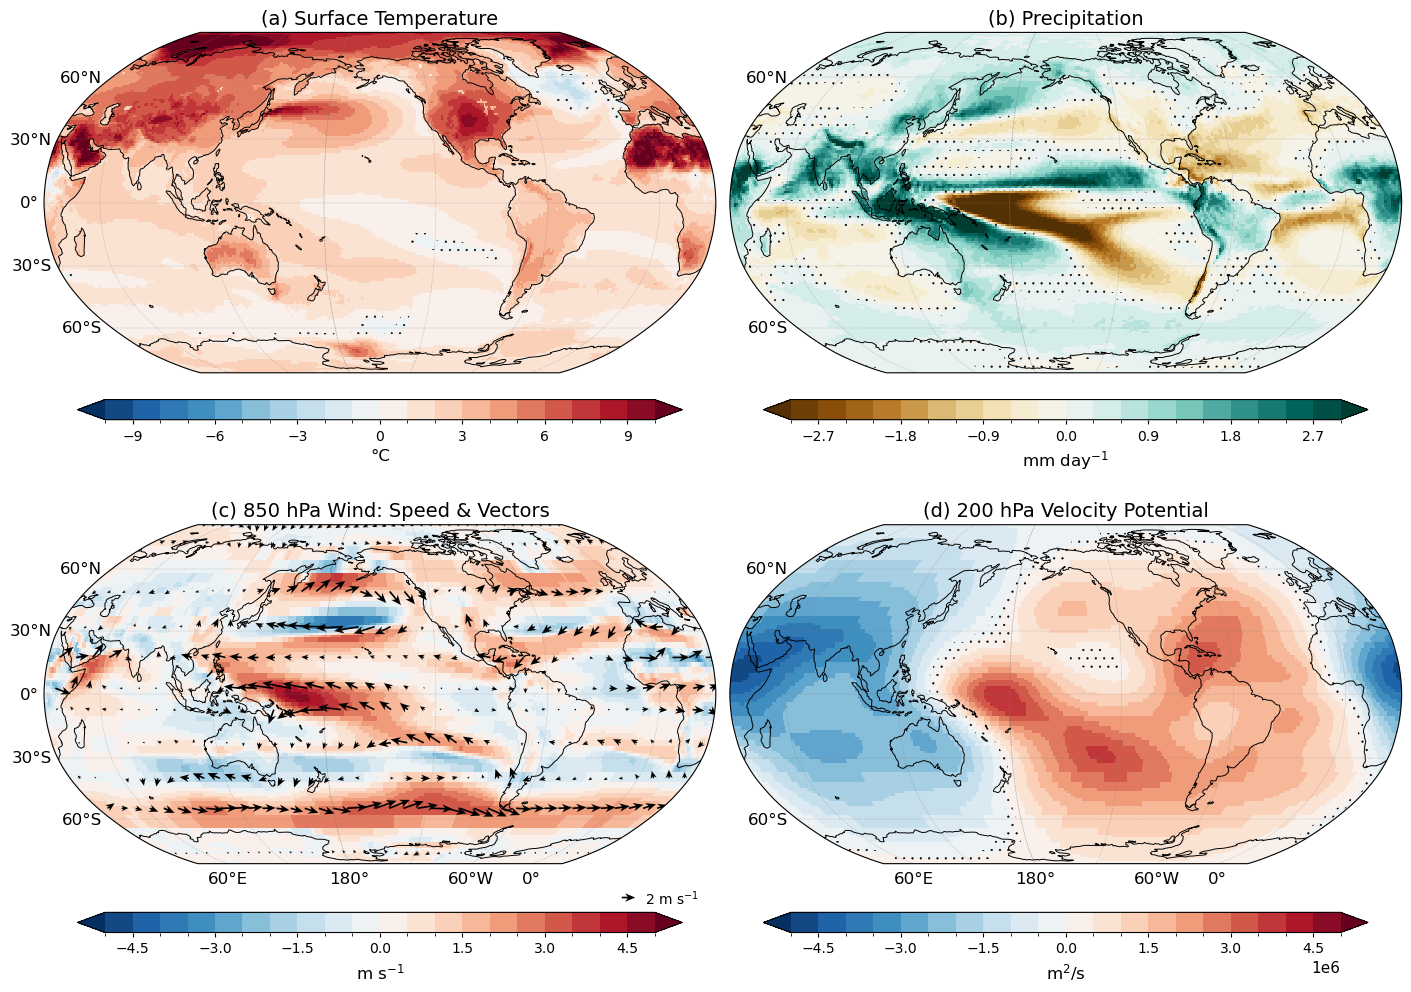

In [70]:
data_sintex = {
    "Surface Temperature": (t_diff_sin_zm, "RdBu_r", np.linspace(-10, 10, 21), "°C"),
    "Precipitation": (pr_diff_sin_zm*86400, "BrBG", np.linspace(-3, 3, 21), "mm day$^{-1}$"),
    "850 hPa Wind: Speed & Vectors": (ws850_diff_sin_zero, "RdBu_r", np.linspace(-5,5,21), "m s$^{-1}$",
                                     u850_diff_sin_zm, v850_diff_sin_zm, 100),
    "200 hPa Velocity Potential": (vp_diff_sin_zm, "RdBu_r", np.linspace(-5000000,5000000,21), "m$^2$/s"), 
}

sig_sintex = {
    "Surface Temperature": sig_sin_zero["t"],
    "Precipitation": sig_sin_zero['pr'],
    "850 hPa Wind: Speed & Vectors": (sig_sin_zero["u850"] | sig_sin_zero["v850"]),  # bool mask for vectors

    "200 hPa Velocity Potential": sig_sin_zero['vp'],
}

plot_single_model_2x2(data_sintex, sig_sintex, model_name="SINTEX")


In [71]:
BASE = Path("../../../New_Analysis/updated_files/yearly/CFS/")



FILES = {
    "temp":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_tsurf_interpECHAM.nc",
              "clim_CFS2ALB0_1y_2014_2044_tsurf_interpECHAM.nc"),
    "pr":    ("clim_CFS2ALB_direct0_ter_1y_2014_2074_precip_interpECHAM.nc",
              "clim_CFS2ALB0_1y_2014_2044_precip_interpECHAM.nc"),
    "vp":    ("clim_CFS2ALB_direct0_ter_1y_2014_2074_velopot200_interpECHAM.nc",
              "clim_CFS2ALB0_1y_2014_2044_velopot200_interpECHAM.nc"),
    "u850":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_u850_interpECHAM.nc",
              "clim_CFS2ALB0_1y_2014_2044_u850_interpECHAM.nc"),
    "v850":  ("clim_CFS2ALB_direct0_ter_1y_2014_2074_v850_interpECHAM.nc",
              "clim_CFS2ALB0_1y_2014_2044_v850_interpECHAM.nc"),
}

In [72]:
ds_cfs = {
    "mod":  {k: open_ds(v[0]) for k, v in FILES.items()},
    "zero": {k: open_ds(v[1]) for k, v in FILES.items()},
}

In [73]:
# Map from your ds_sin variable keys -> (mean_var_name, std_var_name)
VARMAP = {
    "temp":  ("tsurf_mean",     "tsurf_std"),
    "pr":    ("precip_mean",    "precip_std"),
    "vp":    ("velopot_mean","velopot_std"),
    "u850":  ("u850_mean",      "u850_std"),
    "v850":  ("v850_mean",      "v850_std"),
}


# results[experiment][variable]["mean"/"std"] -> DataArray
results = {
    exp: {
        var: dict(zip(("mean", "std"), mean_over_time(ds_cfs[exp][var], *VARMAP[var])))
        for var in VARMAP
    }
    for exp in ("mod", "zero")
}

cfs_t_mean,     cfs_t_std     = results["zero"]["temp"]["mean"], results["zero"]["temp"]["std"]
cfs_t_mean_mod, cfs_t_std_mod = results["mod"]["temp"]["mean"],  results["mod"]["temp"]["std"]

cfs_pr_mean,     cfs_pr_std     = results["zero"]["pr"]["mean"], results["zero"]["pr"]["std"]
cfs_pr_mean_mod, cfs_pr_std_mod = results["mod"]["pr"]["mean"],  results["mod"]["pr"]["std"]

cfs_vp_mean,     cfs_vp_std     = results["zero"]["vp"]["mean"], results["zero"]["vp"]["std"]
cfs_vp_mean_mod, cfs_vp_std_mod = results["mod"]["vp"]["mean"],  results["mod"]["vp"]["std"]

cfs_u850_mean,     cfs_u850_std     = results["zero"]["u850"]["mean"], results["zero"]["u850"]["std"]
cfs_u850_mean_mod, cfs_u850_std_mod = results["mod"]["u850"]["mean"],  results["mod"]["u850"]["std"]

cfs_v850_mean,     cfs_v850_std     = results["zero"]["v850"]["mean"], results["zero"]["v850"]["std"]
cfs_v850_mean_mod, cfs_v850_std_mod = results["mod"]["v850"]["mean"],  results["mod"]["v850"]["std"]


In [74]:
diffs = {
    var: {
        "zero_minus_mod": results["zero"][var]["mean"] - results["mod"][var]["mean"],
    }
    for var in results["mod"]
}

# Optional: keep your old-style variable names (only for the ones you need)
t_diff_cfs_zm    = diffs["temp"]["zero_minus_mod"]
pr_diff_cfs_zm   = diffs["pr"]["zero_minus_mod"]
vp_diff_cfs_zm   = diffs["vp"]["zero_minus_mod"]
u850_diff_cfs_zm = diffs["u850"]["zero_minus_mod"]
v850_diff_cfs_zm = diffs["v850"]["zero_minus_mod"]

In [75]:
cfs_vars_zero = {
    't'   : (cfs_t_mean,   cfs_t_std,   cfs_t_mean_mod,   cfs_t_std_mod),
    'pr'  : (cfs_pr_mean,  cfs_pr_std,  cfs_pr_mean_mod,  cfs_pr_std_mod),
    'vp'  : (cfs_vp_mean,  cfs_vp_std,  cfs_vp_mean_mod,  cfs_vp_std_mod),
    'u850': (cfs_u850_mean,cfs_u850_std,cfs_u850_mean_mod,cfs_u850_std_mod),
    'v850': (cfs_v850_mean,cfs_v850_std,cfs_v850_mean_mod,cfs_v850_std_mod),
}
N_CFS_CTRL, N_CFS_SENS = 56, 25
N_SIN_CTRL, N_SIN_SENS = 100, 50
t_cfs_zero, p_cfs_zero, sig_cfs_zero = run_all_tests_strict(
    cfs_vars_zero, N_CFS_CTRL, N_CFS_SENS, alpha=0.1
)

In [77]:
ws850_cfs      = np.sqrt(cfs_u850_mean**2      + cfs_v850_mean**2)
ws850_cfs_mod = np.sqrt(cfs_u850_mean_mod**2 + cfs_v850_mean_mod**2)

ws850_diff_cfs_zero = ws850_cfs - ws850_cfs_mod

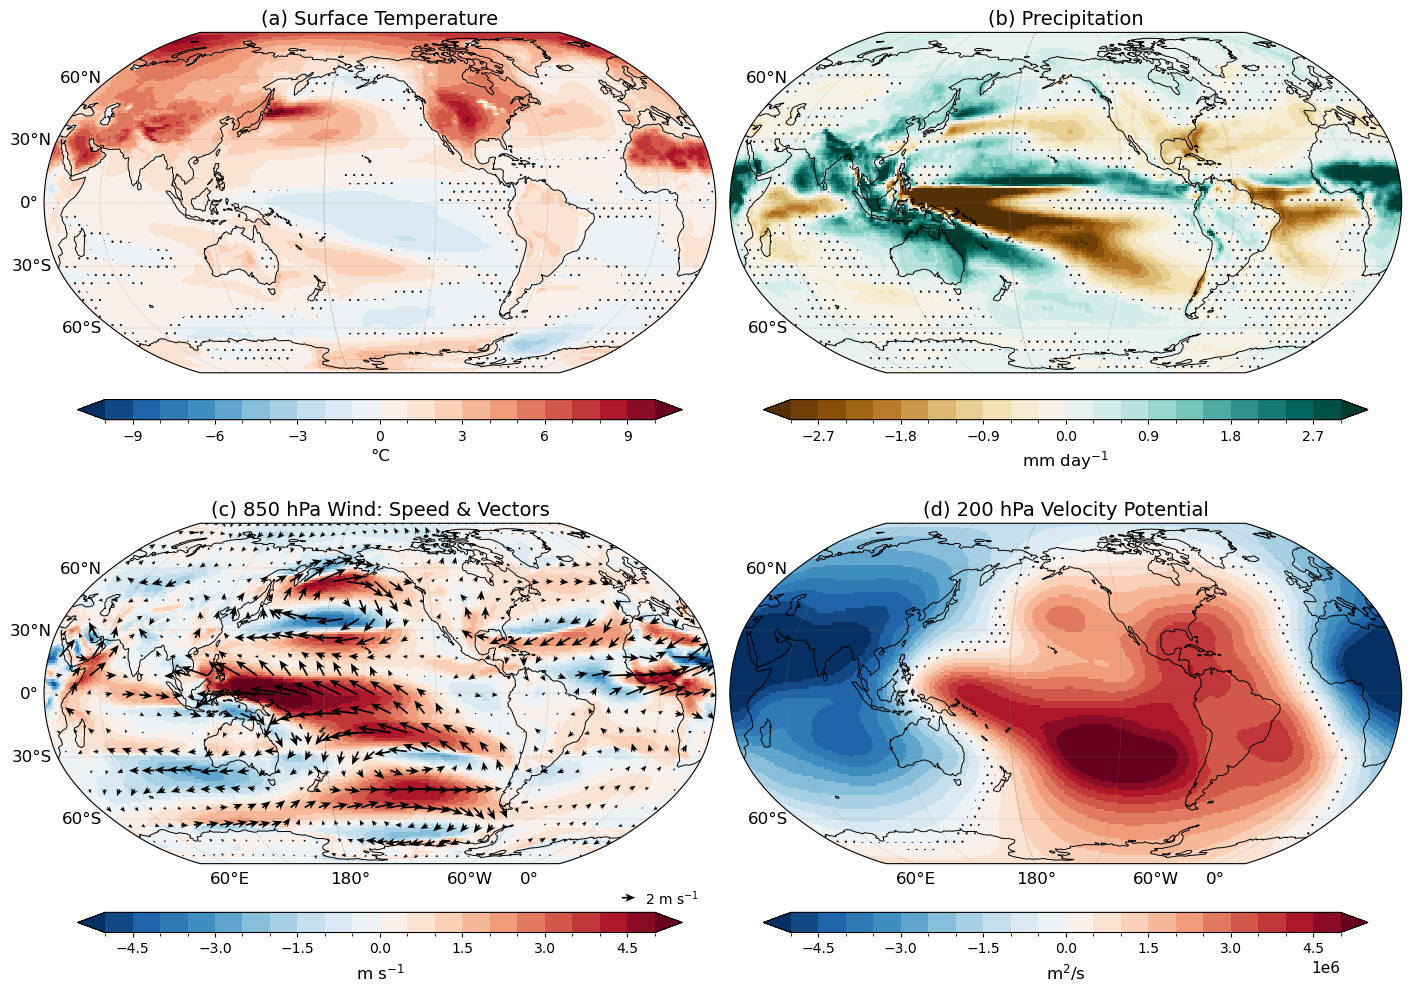

In [78]:
data_cfs = {
    "Surface Temperature": (t_diff_cfs_zm, "RdBu_r", np.linspace(-10, 10, 21), "°C"),
    "Precipitation": (pr_diff_cfs_zm, "BrBG", np.linspace(-3, 3, 21), "mm day$^{-1}$"),
    "850 hPa Wind: Speed & Vectors": (ws850_diff_cfs_zero, "RdBu_r", np.linspace(-5,5,21), "m s$^{-1}$",
                                     u850_diff_cfs_zm, v850_diff_cfs_zm, 100),
    "200 hPa Velocity Potential": (vp_diff_cfs_zm, "RdBu_r", np.linspace(-5000000,5000000,21), "m$^2$/s"), 
}

sig_cfs = {
    "Surface Temperature": sig_cfs_zero["t"],
    "Precipitation": sig_cfs_zero['pr'],
    "850 hPa Wind: Speed & Vectors": (sig_cfs_zero["u850"] | sig_cfs_zero["v850"]),  # bool mask for vectors

    "200 hPa Velocity Potential": sig_cfs_zero['vp'],
}

plot_single_model_2x2(data_cfs, sig_cfs, model_name="CFS")
